In [16]:
!pip install tensorflow==2.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 56.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: go

In [1]:
#Pk/Pd Simulation

#This one-compartment PK modeling is inspired by https://colab.research.google.com/github/jckantor/CBE30338/blob/master/docs/03.05-One-Compartment-Pharmacokinetics.ipynb#scrollTo=ZGTGkRGQIj8Z

#Generating data from a model for repeated dosing

#Here we outline how to define a model for an ODE-LSTM(extension of a Neural Ordinary Differential Equation)

import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import random

#Total span of time space up to 200 hours from first administration
t = np.linspace(0, 200, 1000)

# Function definition for dosing
def u_constant(t, Udose, tdose, td):
    if t % tdose <= td:
        return Udose / td
    else:
        return 0

def u_pulse(t, Udose, tdose, td):
    if t % tdose == 0:
        return Udose / td
    else:
        return 0

def u_decay(t, Udose, tdose, td):
    if t % tdose <= td:
        return Udose / td * np.exp(-(t % tdose) / td)
    else:
        return 0

# Define the derivative function for concentration change
def deriv(C, t, u_func, Udose, tdose, td):
    k = 0.1  # Example elimination rate constant
    dCdt = -k * C + u_func(t, Udose, tdose, td)
    return dCdt

# Initial concentration
Cinitial = 0
#Number of regimen possibilities we want to simulate
num_regimens = 100

parameter_combinations = []
for _ in range(num_regimens):
    td = random.uniform(1, 5)  # Random length of administration for a single dose between 1 and 5 hours
    tdose = random.uniform(4, 12)  # Random time between doses between 4 and 12 hours
    Udose = random.uniform(20, 60)  # Random dose between 20 and 60 mg

    parameter_combinations.append({'td': td, 'tdose': tdose, 'Udose': Udose})

# List to store concentration profiles for each regimen
concentration_profiles = []

# Simulate data for each dosing regimen
for i, parameters in enumerate(parameter_combinations):
    td = parameters['td']
    tdose = parameters['tdose']
    Udose = parameters['Udose']

    C = odeint(deriv, Cinitial, t, args=(u_constant, Udose, tdose, td))
    concentration_profiles.append({'name': f"Regimen {i+1}", 'concentration': C})


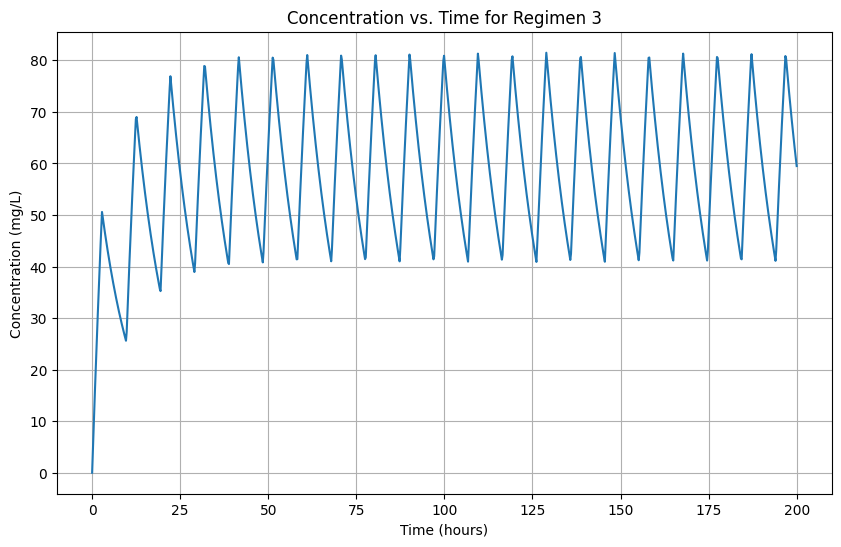

In [2]:
#Visualise simulation results

import random
import matplotlib.pyplot as plt

# Select a regimen at random to visualise
random_profile = concentration_profiles[2]

# Plot the concentration profile for the selected regimen
plt.figure(figsize=(10, 6))
plt.plot(t, random_profile['concentration'])
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (mg/L)')
plt.title(f'Concentration vs. Time for {random_profile["name"]}')
plt.grid(True)
plt.show()

In [3]:
# Copyright 2021 The ODE-LSTM Authors. All Rights Reserved.

import tensorflow as tf
import numpy as np


class CTRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, method, num_unfolds=None, tau=1, **kwargs):
        self.fixed_step_methods = {
            "euler": self.euler,
            "heun": self.heun,
            "rk4": self.rk4,
        }
        allowed_methods = ["euler", "heun", "rk4", "dopri5"]
        if not method in allowed_methods:
            raise ValueError(
                "Unknown ODE solver '{}', expected one of '{}'".format(
                    method, allowed_methods
                )
            )
        if method in self.fixed_step_methods.keys() and num_unfolds is None:
            raise ValueError(
                "Fixed-step ODE solver requires argument 'num_unfolds' to be specified!"
            )
        self.units = units
        self.state_size = units
        self.num_unfolds = num_unfolds
        self.method = method
        self.tau = tau
        super(CTRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        input_dim = input_shape[-1]
        if isinstance(input_shape[0], tuple):
            # Nested tuple
            input_dim = input_shape[0][-1]

        self.kernel = self.add_weight(
            shape=(input_dim, self.units), initializer="glorot_uniform", name="kernel"
        )
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer="orthogonal",
            name="recurrent_kernel",
        )
        self.bias = self.add_weight(
            shape=(self.units), initializer=tf.keras.initializers.Zeros(), name="bias"
        )
        self.scale = self.add_weight(
            shape=(self.units),
            initializer=tf.keras.initializers.Constant(1.0),
            name="scale",
        )
        if self.method == "dopri5":
            # Only load tfp packge if it is really needed
            import tensorflow_probability as tfp

            # We don't need the most precise solver to speed up training
            self.solver = tfp.math.ode.DormandPrince(
                rtol=0.01,
                atol=1e-04,
                first_step_size=0.01,
                safety_factor=0.8,
                min_step_size_factor=0.1,
                max_step_size_factor=10.0,
                max_num_steps=None,
                make_adjoint_solver_fn=None,
                validate_args=False,
                name="dormand_prince",
            )
        self.built = True

    def call(self, inputs, states):
        hidden_state = states[0]
        elapsed = 1.0
        if (isinstance(inputs, tuple) or isinstance(inputs, list)) and len(inputs) > 1:
            elapsed = inputs[1]
            inputs = inputs[0]

        if self.method == "dopri5":
            # Only load tfp packge if it is really needed
            import tensorflow_probability as tfp

            if not type(elapsed) == float:
                batch_dim = tf.shape(elapsed)[0]
                elapsed = tf.reshape(elapsed, [batch_dim])

                idx = tf.argsort(elapsed)
                solution_times = tf.gather(elapsed, idx)
            else:
                solution_times = elapsed
            hidden_state = states[0]
            res = self.solver.solve(
                ode_fn=self.dfdt_wrapped,
                initial_time=0,
                initial_state=hidden_state,
                solution_times=solution_times,  # tfp.math.ode.ChosenBySolver(elapsed),
                constants={"input": inputs},
            )
            if not type(elapsed) == float:
                i2 = tf.stack([idx, tf.range(batch_dim)], axis=1)
                hidden_state = tf.gather_nd(res.states, i2)
            else:
                hidden_state = res.states[-1]
        else:
            delta_t = elapsed / self.num_unfolds
            method = self.fixed_step_methods[self.method]
            for i in range(self.num_unfolds):
                hidden_state = method(inputs, hidden_state, delta_t)
        return hidden_state, [hidden_state]

    def dfdt_wrapped(self, t, y, **constants):
        inputs = constants["input"]
        hidden_state = y
        return self.dfdt(inputs, hidden_state)

    def dfdt(self, inputs, hidden_state):
        h_in = tf.matmul(inputs, self.kernel)
        h_rec = tf.matmul(hidden_state, self.recurrent_kernel)
        dh_in = self.scale * tf.nn.tanh(h_in + h_rec + self.bias)
        if self.tau > 0:
            dh = dh_in - hidden_state * self.tau
        else:
            dh = dh_in
        return dh

    def euler(self, inputs, hidden_state, delta_t):
        dy = self.dfdt(inputs, hidden_state)
        return hidden_state + delta_t * dy

    def heun(self, inputs, hidden_state, delta_t):
        k1 = self.dfdt(inputs, hidden_state)
        k2 = self.dfdt(inputs, hidden_state + delta_t * k1)
        return hidden_state + delta_t * 0.5 * (k1 + k2)

    def rk4(self, inputs, hidden_state, delta_t):
        k1 = self.dfdt(inputs, hidden_state)
        k2 = self.dfdt(inputs, hidden_state + k1 * delta_t * 0.5)
        k3 = self.dfdt(inputs, hidden_state + k2 * delta_t * 0.5)
        k4 = self.dfdt(inputs, hidden_state + k3 * delta_t)

        return hidden_state + delta_t * (k1 + 2 * k2 + 2 * k3 + k4) / 6.0


class LSTMCell(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = (units, units)
        self.initializer = "glorot_uniform"
        self.recurrent_initializer = "orthogonal"
        super(LSTMCell, self).__init__(**kwargs)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return (
            tf.zeros([batch_size, self.units], dtype=tf.float32),
            tf.zeros([batch_size, self.units], dtype=tf.float32),
        )

    def build(self, input_shape):
        if isinstance(input_shape[0], tuple):
            # Nested tuple
            input_shape = (input_shape[0][-1] + input_shape[1][-1],)

        self.input_kernel = self.add_weight(
            shape=(input_shape[-1], 4 * self.units),
            initializer=self.initializer,
            name="input_kernel",
        )
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, 4 * self.units),
            initializer=self.recurrent_initializer,
            name="recurrent_kernel",
        )
        self.bias = self.add_weight(
            shape=(4 * self.units),
            initializer=tf.keras.initializers.Zeros(),
            name="bias",
        )

        self.built = True

    def call(self, inputs, states):
        cell_state, output_state = states
        if (isinstance(inputs, tuple) or isinstance(inputs, list)) and len(inputs) > 1:
            inputs = tf.concat([inputs[0], inputs[1]], axis=-1)

        z = (
            tf.matmul(inputs, self.input_kernel)
            + tf.matmul(output_state, self.recurrent_kernel)
            + self.bias
        )
        i, ig, fg, og = tf.split(z, 4, axis=-1)

        input_activation = tf.nn.tanh(i)
        input_gate = tf.nn.sigmoid(ig)
        forget_gate = tf.nn.sigmoid(fg + 1.0)
        output_gate = tf.nn.sigmoid(og)

        new_cell = cell_state * forget_gate + input_activation * input_gate
        output_state = tf.nn.tanh(new_cell) * output_gate

        return output_state, [new_cell, output_state]


class ODELSTM(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = (units, units)
        self.initializer = "glorot_uniform"
        self.recurrent_initializer = "orthogonal"
        self.ctrnn = CTRNNCell(self.units, num_unfolds=4, method="euler")
        super(ODELSTM, self).__init__(**kwargs)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return (
            tf.zeros([batch_size, self.units], dtype=tf.float32),
            tf.zeros([batch_size, self.units], dtype=tf.float32),
        )

    def build(self, input_shape):
        input_dim = input_shape[-1]
        if isinstance(input_shape[0], tuple):
            # Nested tuple
            input_dim = input_shape[0][-1]

        self.ctrnn.build([self.units])
        self.input_kernel = self.add_weight(
            shape=(input_dim, 4 * self.units),
            initializer=self.initializer,
            name="input_kernel",
        )
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, 4 * self.units),
            initializer=self.recurrent_initializer,
            name="recurrent_kernel",
        )
        self.bias = self.add_weight(
            shape=(4 * self.units),
            initializer=tf.keras.initializers.Zeros(),
            name="bias",
        )

        self.built = True

    def call(self, inputs, states):
        cell_state, ode_state = states
        elapsed = 1.0
        if (isinstance(inputs, tuple) or isinstance(inputs, list)) and len(inputs) > 1:
            elapsed = inputs[1]
            inputs = inputs[0]

        z = (
            tf.matmul(inputs, self.input_kernel)
            + tf.matmul(ode_state, self.recurrent_kernel)
            + self.bias
        )
        i, ig, fg, og = tf.split(z, 4, axis=-1)

        input_activation = tf.nn.tanh(i)
        input_gate = tf.nn.sigmoid(ig)
        forget_gate = tf.nn.sigmoid(fg + 3.0)
        output_gate = tf.nn.sigmoid(og)

        new_cell = cell_state * forget_gate + input_activation * input_gate
        ode_input = tf.nn.tanh(new_cell) * output_gate

        # Implementation choice on how to parametrize ODE component
        ode_output, new_ode_state = self.ctrnn.call([ode_input, elapsed], [ode_state])
        # ode_output, new_ode_state = self.ctrnn.call([ode_input, elapsed], [ode_input])

        return ode_output, [new_cell, new_ode_state[0]]


class CTGRU(tf.keras.layers.Layer):
    # https://arxiv.org/abs/1710.04110
    def __init__(self, units, M=8, **kwargs):
        self.units = units
        self.M = M
        self.state_size = units * self.M

        # Pre-computed tau table (as recommended in paper)
        self.ln_tau_table = np.empty(self.M)
        self.tau_table = np.empty(self.M)
        tau = 1.0
        for i in range(self.M):
            self.ln_tau_table[i] = np.log(tau)
            self.tau_table[i] = tau
            tau = tau * (10.0 ** 0.5)

        super(CTGRU, self).__init__(**kwargs)

    def build(self, input_shape):
        input_dim = input_shape[-1]
        if isinstance(input_shape[0], tuple):
            # Nested tuple
            input_dim = input_shape[0][-1]

        self.retrieval_layer = tf.keras.layers.Dense(
            self.units * self.M, activation=None
        )
        self.detect_layer = tf.keras.layers.Dense(self.units, activation="tanh")
        self.update_layer = tf.keras.layers.Dense(self.units * self.M, activation=None)
        self.built = True

    def call(self, inputs, states):
        elapsed = 1.0
        if (isinstance(inputs, tuple) or isinstance(inputs, list)) and len(inputs) > 1:
            elapsed = inputs[1]
            inputs = inputs[0]

        batch_dim = tf.shape(inputs)[0]

        # States is actually 2D
        h_hat = tf.reshape(states[0], [batch_dim, self.units, self.M])
        h = tf.reduce_sum(h_hat, axis=2)
        states = None  # Set state to None, to avoid misuses (bugs) in the code below

        # Retrieval
        fused_input = tf.concat([inputs, h], axis=-1)
        ln_tau_r = self.retrieval_layer(fused_input)
        ln_tau_r = tf.reshape(ln_tau_r, shape=[batch_dim, self.units, self.M])
        sf_input_r = -tf.square(ln_tau_r - self.ln_tau_table)
        rki = tf.nn.softmax(logits=sf_input_r, axis=2)

        q_input = tf.reduce_sum(rki * h_hat, axis=2)
        reset_value = tf.concat([inputs, q_input], axis=1)
        qk = self.detect_layer(reset_value)
        qk = tf.reshape(qk, [batch_dim, self.units, 1])  # in order to broadcast

        ln_tau_s = self.update_layer(fused_input)
        ln_tau_s = tf.reshape(ln_tau_s, shape=[batch_dim, self.units, self.M])
        sf_input_s = -tf.square(ln_tau_s - self.ln_tau_table)
        ski = tf.nn.softmax(logits=sf_input_s, axis=2)

        # Now the elapsed time enters the state update
        base_term = (1 - ski) * h_hat + ski * qk
        exp_term = tf.exp(-elapsed / self.tau_table)
        exp_term = tf.reshape(exp_term, [batch_dim, 1, self.M])
        h_hat_next = base_term * exp_term

        # Compute new state
        h_next = tf.reduce_sum(h_hat_next, axis=2)
        h_hat_next_flat = tf.reshape(h_hat_next, shape=[batch_dim, self.units * self.M])
        return h_next, [h_hat_next_flat]


class VanillaRNN(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units

        super(VanillaRNN, self).__init__(**kwargs)

    def build(self, input_shape):
        input_dim = input_shape[-1]
        if isinstance(input_shape[0], tuple):
            # Nested tuple
            input_dim = input_shape[0][-1]

        self._layer = tf.keras.layers.Dense(self.units, activation="tanh")
        self._out_layer = tf.keras.layers.Dense(self.units, activation=None)
        self._tau = self.add_weight(
            "tau",
            shape=(self.units),
            dtype=tf.float32,
            initializer=tf.keras.initializers.Constant(0.1),
        )
        self.built = True

    def call(self, inputs, states):
        elapsed = 1.0
        if (isinstance(inputs, tuple) or isinstance(inputs, list)) and len(inputs) > 1:
            elapsed = inputs[1]
            inputs = inputs[0]

        fused_input = tf.concat([inputs, states[0]], axis=-1)
        new_states = self._out_layer(self._layer(fused_input)) - elapsed * self._tau

        return new_states, [new_states]


class BidirectionalRNN(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = (units, units, units)

        self.ctrnn = CTRNNCell(self.units, num_unfolds=4, method="euler")
        self.lstm = LSTMCell(units=self.units)

        super(BidirectionalRNN, self).__init__(**kwargs)

    def build(self, input_shape):
        input_dim = input_shape[-1]
        if isinstance(input_shape[0], tuple):
            # Nested tuple
            input_dim = input_shape[0][-1]
        self._out_layer = tf.keras.layers.Dense(self.units, activation=None)
        fused_dim = ((input_dim + self.units,), (1,))
        self.lstm.build(fused_dim)
        self.ctrnn.build(fused_dim)
        self.built = True

    def call(self, inputs, states):
        elapsed = 1.0
        if (isinstance(inputs, tuple) or isinstance(inputs, list)) and len(inputs) > 1:
            elapsed = inputs[1]
            inputs = inputs[0]

        lstm_state = [states[0], states[1]]
        lstm_input = [tf.concat([inputs, states[2]], axis=-1), elapsed]
        ctrnn_state = [states[2]]
        ctrnn_input = [tf.concat([inputs, states[1]], axis=-1), elapsed]

        lstm_out, new_lstm_states = self.lstm.call(lstm_input, lstm_state)
        ctrnn_out, new_ctrnn_state = self.ctrnn.call(ctrnn_input, ctrnn_state)

        fused_output = lstm_out + ctrnn_out
        return (
            fused_output,
            [new_lstm_states[0], new_lstm_states[1], new_ctrnn_state[0]],
        )


class GRUD(tf.keras.layers.Layer):
    # Implemented according to
    # https://www.nature.com/articles/s41598-018-24271-9.pdf
    # without the masking

    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super(GRUD, self).__init__(**kwargs)

    def build(self, input_shape):
        input_dim = input_shape[-1]
        if isinstance(input_shape[0], tuple):
            # Nested tuple
            input_dim = input_shape[0][-1]

        self._reset_gate = tf.keras.layers.Dense(
            self.units, activation="sigmoid", kernel_initializer="glorot_uniform"
        )
        self._detect_signal = tf.keras.layers.Dense(
            self.units, activation="tanh", kernel_initializer="glorot_uniform"
        )
        self._update_gate = tf.keras.layers.Dense(
            self.units, activation="sigmoid", kernel_initializer="glorot_uniform"
        )
        self._d_gate = tf.keras.layers.Dense(
            self.units, activation="relu", kernel_initializer="glorot_uniform"
        )

        self.built = True

    def call(self, inputs, states):
        elapsed = 1.0
        if (isinstance(inputs, tuple) or isinstance(inputs, list)) and len(inputs) > 1:
            elapsed = inputs[1]
            inputs = inputs[0]

        dt = self._d_gate(elapsed)
        gamma = tf.exp(-dt)
        h_hat = states[0] * gamma

        fused_input = tf.concat([inputs, h_hat], axis=-1)
        rt = self._reset_gate(fused_input)
        zt = self._update_gate(fused_input)

        reset_value = tf.concat([inputs, rt * h_hat], axis=-1)
        h_tilde = self._detect_signal(reset_value)

        # Compute new state
        ht = zt * h_hat + (1.0 - zt) * h_tilde

        return ht, [ht]


class PhasedLSTM(tf.keras.layers.Layer):
    # Implemented according to
    # https://papers.nips.cc/paper/6310-phased-lstm-accelerating-recurrent-network-training-for-long-or-event-based-sequences.pdf

    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = (units, units)
        self.initializer = "glorot_uniform"
        self.recurrent_initializer = "orthogonal"
        super(PhasedLSTM, self).__init__(**kwargs)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return (
            tf.zeros([batch_size, self.units], dtype=tf.float32),
            tf.zeros([batch_size, self.units], dtype=tf.float32),
        )

    def build(self, input_shape):
        input_dim = input_shape[-1]
        if isinstance(input_shape[0], tuple):
            # Nested tuple
            input_dim = input_shape[0][-1]

        self.input_kernel = self.add_weight(
            shape=(input_dim, 4 * self.units),
            initializer=self.initializer,
            name="input_kernel",
        )
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, 4 * self.units),
            initializer=self.recurrent_initializer,
            name="recurrent_kernel",
        )
        self.bias = self.add_weight(
            shape=(4 * self.units),
            initializer=tf.keras.initializers.Zeros(),
            name="bias",
        )
        self.tau = self.add_weight(
            shape=(1,), initializer=tf.keras.initializers.Zeros(), name="tau"
        )
        self.ron = self.add_weight(
            shape=(1,), initializer=tf.keras.initializers.Zeros(), name="ron"
        )
        self.s = self.add_weight(
            shape=(1,), initializer=tf.keras.initializers.Zeros(), name="s"
        )

        self.built = True

    def call(self, inputs, states):
        cell_state, hidden_state = states
        elapsed = 1.0
        if (isinstance(inputs, tuple) or isinstance(inputs, list)) and len(inputs) > 1:
            elapsed = inputs[1]
            inputs = inputs[0]

        # Leaky constant taken fromt he paper
        alpha = 0.001
        # Make sure these values are positive
        tau = tf.nn.softplus(self.tau)
        s = tf.nn.softplus(self.s)
        ron = tf.nn.softplus(self.ron)

        phit = tf.math.mod(elapsed - s, tau) / tau
        kt = tf.where(
            tf.less(phit, 0.5 * ron),
            2 * phit * ron,
            tf.where(tf.less(phit, ron), 2.0 - 2 * phit / ron, alpha * phit),
        )

        z = (
            tf.matmul(inputs, self.input_kernel)
            + tf.matmul(hidden_state, self.recurrent_kernel)
            + self.bias
        )
        i, ig, fg, og = tf.split(z, 4, axis=-1)

        input_activation = tf.nn.tanh(i)
        input_gate = tf.nn.sigmoid(ig)
        forget_gate = tf.nn.sigmoid(fg + 1.0)
        output_gate = tf.nn.sigmoid(og)

        c_tilde = cell_state * forget_gate + input_activation * input_gate
        c = kt * c_tilde + (1.0 - kt) * cell_state

        h_tilde = tf.nn.tanh(c_tilde) * output_gate
        h = kt * h_tilde + (1.0 - kt) * hidden_state

        return h, [c, h]


class GRUODE(tf.keras.layers.Layer):
    # Implemented according to
    # https://arxiv.org/pdf/1905.12374.pdf
    # without the Bayesian stuff

    def __init__(self, units, num_unfolds=4, **kwargs):
        self.units = units
        self.num_unfolds = num_unfolds
        self.state_size = units
        super(GRUODE, self).__init__(**kwargs)

    def build(self, input_shape):
        input_dim = input_shape[-1]
        if isinstance(input_shape[0], tuple):
            # Nested tuple
            input_dim = input_shape[0][-1]
        self._reset_gate = tf.keras.layers.Dense(
            self.units,
            activation="sigmoid",
            bias_initializer=tf.constant_initializer(1),
        )
        self._detect_signal = tf.keras.layers.Dense(self.units, activation="tanh")
        self._update_gate = tf.keras.layers.Dense(self.units, activation="sigmoid")

        self.built = True

    def _dh_dt(self, inputs, states):
        fused_input = tf.concat([inputs, states], axis=-1)
        rt = self._reset_gate(fused_input)
        zt = self._update_gate(fused_input)

        reset_value = tf.concat([inputs, rt * states], axis=-1)
        gt = self._detect_signal(reset_value)

        # Compute new state
        dhdt = (1.0 - zt) * (gt - states)
        return dhdt

    def euler(self, inputs, hidden_state, delta_t):
        dy = self._dh_dt(inputs, hidden_state)
        return hidden_state + delta_t * dy

    def call(self, inputs, states):
        elapsed = 1.0
        if (isinstance(inputs, tuple) or isinstance(inputs, list)) and len(inputs) > 1:
            elapsed = inputs[1]
            inputs = inputs[0]

        delta_t = elapsed / self.num_unfolds
        hidden_state = states[0]
        for i in range(self.num_unfolds):
            hidden_state = self.euler(inputs, hidden_state, delta_t)
        return hidden_state, [hidden_state]

        return ht, [ht]


class HawkLSTMCell(tf.keras.layers.Layer):
    # https://papers.nips.cc/paper/7252-the-neural-hawkes-process-a-neurally-self-modulating-multivariate-point-process.pdf
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = (units, units, units)  # state is a tripple
        self.initializer = "glorot_uniform"
        self.recurrent_initializer = "orthogonal"
        super(HawkLSTMCell, self).__init__(**kwargs)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return (
            tf.zeros([batch_size, self.units], dtype=tf.float32),
            tf.zeros([batch_size, self.units], dtype=tf.float32),
            tf.zeros([batch_size, self.units], dtype=tf.float32),
        )

    def build(self, input_shape):
        input_dim = input_shape[-1]
        if isinstance(input_shape[0], tuple):
            # Nested tuple
            input_dim = input_shape[0][-1]
        self.input_kernel = self.add_weight(
            shape=(input_dim, 7 * self.units),
            initializer=self.initializer,
            name="input_kernel",
        )
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, 7 * self.units),
            initializer=self.recurrent_initializer,
            name="recurrent_kernel",
        )
        self.bias = self.add_weight(
            shape=(7 * self.units),
            initializer=tf.keras.initializers.Zeros(),
            name="bias",
        )

        self.built = True

    def call(self, inputs, states):
        c, c_bar, h = states
        k = inputs[0]  # Is the input
        delta_t = inputs[1]  # is the elapsed time

        z = (
            tf.matmul(k, self.input_kernel)
            + tf.matmul(h, self.recurrent_kernel)
            + self.bias
        )
        i, ig, fg, og, ig_bar, fg_bar, d = tf.split(z, 7, axis=-1)

        input_activation = tf.nn.tanh(i)
        input_gate = tf.nn.sigmoid(ig)
        input_gate_bar = tf.nn.sigmoid(ig_bar)
        forget_gate = tf.nn.sigmoid(fg)
        forget_gate_bar = tf.nn.sigmoid(fg_bar)
        output_gate = tf.nn.sigmoid(og)
        delta_gate = tf.nn.softplus(d)

        new_c = c * forget_gate + input_activation * input_gate
        new_c_bar = c_bar * forget_gate_bar + input_activation * input_gate_bar

        c_t = new_c_bar + (new_c - new_c_bar) * tf.exp(-delta_gate * delta_t)
        output_state = tf.nn.tanh(c_t) * output_gate

        return output_state, [new_c, new_c_bar, output_state]

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization,Dropout, Reshape, Conv1D, Flatten, RNN


# Prepare the features and target variable
X = np.array([[regimen['td'], regimen['tdose'], regimen['Udose']] for regimen in parameter_combinations])
y = np.array([profile['concentration'].flatten() for profile in concentration_profiles])

# Reshape X to represent sequences (samples, timesteps, features)
X = X.reshape(X.shape[0], 1, X.shape[1])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define the neural network architecture
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Conv1D(padding="same", kernel_size=3, filters=32))
model.add(Flatten())
model.add(Reshape((1, -1)))
model.add(RNN(ODELSTM(units=64), time_major=False, return_sequences=True))
model.add(Flatten())
model.add(Reshape((1,-1)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(y_train.shape[1]))


# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
mse = model.evaluate(X_test, y_test, verbose=0)
print("Mean Squared Error:", mse)


Epoch 1/200
3/3 [==============================] - 7s 310ms/step - loss: 3618.9907 - val_loss: 3626.3884
Epoch 2/200
3/3 [==============================] - 0s 25ms/step - loss: 3617.8684 - val_loss: 3623.7063
Epoch 3/200
3/3 [==============================] - 0s 23ms/step - loss: 3614.4070 - val_loss: 3616.3916
Epoch 4/200
3/3 [==============================] - 0s 24ms/step - loss: 3605.5166 - val_loss: 3598.2712
Epoch 5/200
3/3 [==============================] - 0s 31ms/step - loss: 3583.4312 - val_loss: 3555.5876
Epoch 6/200
3/3 [==============================] - 0s 22ms/step - loss: 3533.4421 - val_loss: 3459.1965
Epoch 7/200
3/3 [==============================] - 0s 22ms/step - loss: 3418.7209 - val_loss: 3256.9119
Epoch 8/200
3/3 [==============================] - 0s 33ms/step - loss: 3194.1609 - val_loss: 2869.6462
Epoch 9/200
3/3 [==============================] - 0s 23ms/step - loss: 2766.3586 - val_loss: 2219.2520
Epoch 10/200
3/3 [==============================] - 0s 31ms/ste

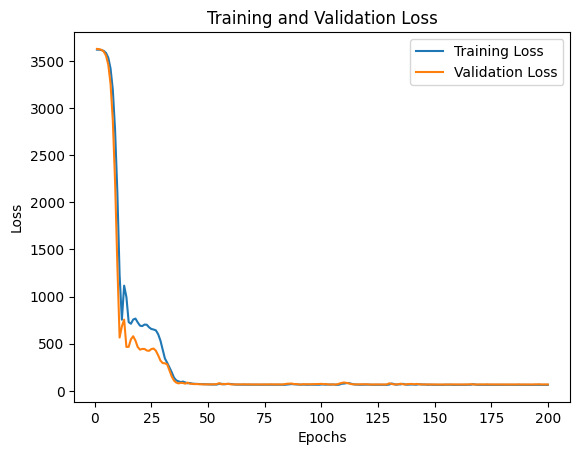

In [5]:
#Plot Losses

# Get the loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

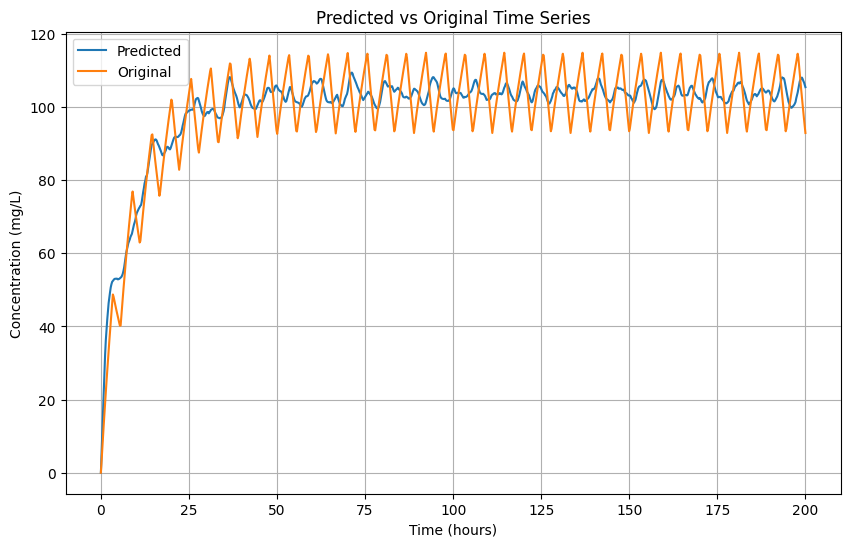

In [11]:
# Choose a random index to select a specific combination of parameters from the test set
chosen_index = random.randint(0, len(X_test) - 1)
chosen_X = X_test[chosen_index].reshape(1, 1, 3)  # Reshape for LSTM input
chosen_y_true = y_test[chosen_index]

# Predict concentration profile using the model
chosen_y_pred = model.predict(chosen_X).flatten()

# Plot the original and predicted time series
plt.figure(figsize=(10, 6))
plt.plot(t, chosen_y_pred, label='Predicted')
plt.plot(t, chosen_y_true, label='Original')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (mg/L)')
plt.title('Predicted vs Original Time Series')
plt.legend()
plt.grid(True)
plt.show()